# Qualitätsbewertung der Ladekurven

In dieses Notebook, versuchen wir ein Wert zu erstellen, um die Qualität eines Chargepoints zu beurteilen. Das Ziel ist dieses Werts zu nutzen, unter anderen, um der Ladevorgangsqualität bzw. Ladedauer an dieser Ladepunkt einschätzen/vorhersagen.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Beste-ChargePoint-Bestimmung" data-toc-modified-id="Beste-ChargePoint-Bestimmung-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Beste ChargePoint Bestimmung</a></span><ul class="toc-item"><li><span><a href="#Umsetzung" data-toc-modified-id="Umsetzung-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Umsetzung</a></span></li></ul></li><li><span><a href="#Qualitätsbewertung" data-toc-modified-id="Qualitätsbewertung-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Qualitätsbewertung</a></span></li><li><span><a href="#Andere-Hersteller" data-toc-modified-id="Andere-Hersteller-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Andere Hersteller</a></span><ul class="toc-item"><li><span><a href="#Kia-eNiro" data-toc-modified-id="Kia-eNiro-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Kia eNiro</a></span></li><li><span><a href="#Tesla" data-toc-modified-id="Tesla-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Tesla</a></span></li></ul></li><li><span><a href="#Zusammenfassung" data-toc-modified-id="Zusammenfassung-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Zusammenfassung</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime, sys, datetime, warnings
sys.path.append('../chargecurve/')
from databases import load_base2_ftp, query_station
from functions import get_peaks, collect_charges
from chargecurve import AutoCharge, ChargingCurve
from plot import charges, chargecurvestation, fullchargecurve
from sklearn.metrics import auc 

warnings.filterwarnings('ignore')

## Beste ChargePoint Bestimmung

Für die Einschätzung der Beste Charge Point müssen wir erstens eine Metrik finden, die uns eine Quantifizierung des Ladevorgangs gibt. Wenn wir so was haben, dann es ist möglich Ladevorgänge bzw. Ladekurven zu vergleichen.

Mögliche Metrik die wir nutzen können sind:

+ **Summe (Alle Ladekurve werte addieren):** Diese Metrik  vernachlässigen wir, da es einige Charge Points Kurven gibt, die viel mehr Punkte haben als andere. Diese punkte addieren sich zu dem Endwert ohne eine wahre Bedeutung.


+ **Maximale Ladeleistung**: Diese Metrik sollten wir ebenfalls vernachlässigen, da sie sich stark von Ausreißer Punkte beeinflusst würde.


+ **Mittelwert oder Medianwert:**  Wir müssen den Mittelwert und den Median sorgfältig prüfen, da der Mittelwert auch von Ausreißern beeinflusst wird. Der Median ist wahrscheinlich der sicherste Metrik dazwischen die beiden.


+ **Integration (Fläche unter der Kurve)** Dieses Metrik  ist wahrscheinlich nicht von Ausreißer beeinflusst und es konnte die beste Losung für unseren Zweck sein, allerdings, sie benötigt die Kurven vollständig zu sein, um die miteinander zu vergleichen. 

### Umsetzung

Für die Bestimmung  die oben genannte Metrik nehmen wir Ladeleistung Daten für SoC zwischen 20% und 80%.

Jetzt, überprüfen wir die verschiedenen Metrik für 50kW-Ladepunktkurven.

Aber erst, rufen wir Ladedaten von Autos. In diesen Beispiel untersuchen wir Hyundai Ioniq Daten.

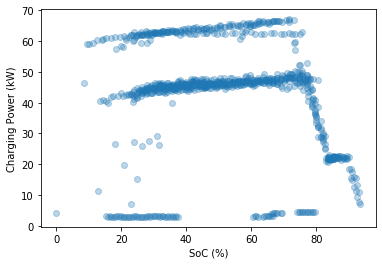

In [2]:
#load hyundai data
hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select while charging data, for Hyundai the conditions are as below
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2019,12,1)) 

#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

hyundai_charges = collect_charges(hyundai[mask], peaks_id)
#plot all charging curves
#chargecurvestation(hyundai_charges)

# instantiate the ChargingCurve object
HyundaiChargeCurve = ChargingCurve(hyundai_charges)

#plot the complete Charging Curve for this Auto
HyundaiChargeCurve.plotCurve()

In [3]:
#Define functions to estimate the metrics and plot them for comparison
def sorting(chargecurve,mask):
    
    chargepoints = chargecurve.data[mask].chargepoint_id.unique()

    #extract some  metrics
    df = pd.DataFrame({'chargePoint': [cp for cp in chargepoints],
                      'kw': [chargecurve.ChargePointCurve(cp).chargepoint_kw[mask].unique()[0]
                             if len(chargecurve.ChargePointCurve(cp).chargepoint_kw[mask].unique()) !=0
                             else np.nan for cp in chargepoints],
                       'sum': [chargecurve.ChargePointCurve(cp).power[mask].sum()
                               for cp in chargepoints],
                       'maxPower': [chargecurve.ChargePointCurve(cp).power[mask].max()
                                    for cp in chargepoints],
                       'meanPower': [chargecurve.ChargePointCurve(cp).power[mask].mean()
                                     for cp in chargepoints],
                       'medianPower': [chargecurve.ChargePointCurve(cp).power[mask].median()
                                       for cp in chargepoints],
                       'IntegralPower': [auc(chargecurve.ChargePointCurve(cp).soc_display[mask].values,
                                             chargecurve.ChargePointCurve(cp).power[mask].values)
                                         if pd.notna(cp) else np.nan for cp in chargepoints]
                      })
    return df

def plot_sorting(chargecurve,mask):
    
    sort_condions = ['maxPower', 'meanPower', 'medianPower', 'IntegralPower']

    fig = plt.figure(figsize=(15,10))
    for i, cond in enumerate(sort_condions):
        ax = fig.add_subplot(2,2,i+1)
        res = sorting(chargecurve,mask)
        res_sorted = res.sort_values(by=cond, ascending=False)
        res_sorted = res_sorted.chargePoint[:5]
        for n, cp in enumerate(res_sorted):
            ax.plot(chargecurve.ChargePointCurve(cp).soc_display[mask],
                    chargecurve.ChargePointCurve(cp).power[mask], '.-', 
                    label = '{}: {}'.format(n+1,cp), 
                    c='C{}'.format(res_sorted.index.values[n]))
            plt.title(cond)
            plt.legend()
            plt.xlabel('Soc [%]')
            plt.ylabel('Charging Power [kW]')
            plt.tight_layout()

Unten ist eine Tabelle mit aller die Metrik für Ladekurven von 50kW Charge Points. Zusammen mit ihrer Figuren. Die Plots zeigen die Ladekurven an einer Charge Point zwischen SoC 20% und 80%. Jeder Plot stellt die sortierte Ladekurve nach der Metrik. Zum Beispiel, Plot oben Links zeigt sortierte Kurve nach die maximale Ladeleistung Metrik, Charge Point 103952 ist nach diese Metrik in Platz 1 und Charge Point 95195 in Platz 5.

In [4]:
# define a mask where we consider the curve only for the SoC range between 20% and 80% 
# and charger power of 50kW
mask = (HyundaiChargeCurve.data.soc_display > 20) \
        & (HyundaiChargeCurve.data.soc_display < 80) \
        & (HyundaiChargeCurve.data.chargepoint_kw == 50)

res = sorting(HyundaiChargeCurve,mask)
res

chargePoint    kw          sum   maxPower  meanPower  medianPower  \
0      95195.0  50.0  3003.177882  48.117919  44.823550    44.884101   
1      83102.0  50.0  2755.449731  48.679051  45.171307    45.361999   
2     102112.0  50.0  2448.218413  48.873301  46.192800    46.587502   
3     103086.0  50.0  2489.257664  47.704770  45.259230    45.668319   
4     101149.0  50.0  2670.548441  48.885124  45.263533    45.983199   
5     103952.0  50.0  2239.361810  48.892063  45.701261    46.338601   

   IntegralPower  
0    2653.939083  
1    2664.588308  
2    2436.773973  
3    2470.573282  
4    1440.465900  
5    2220.594271

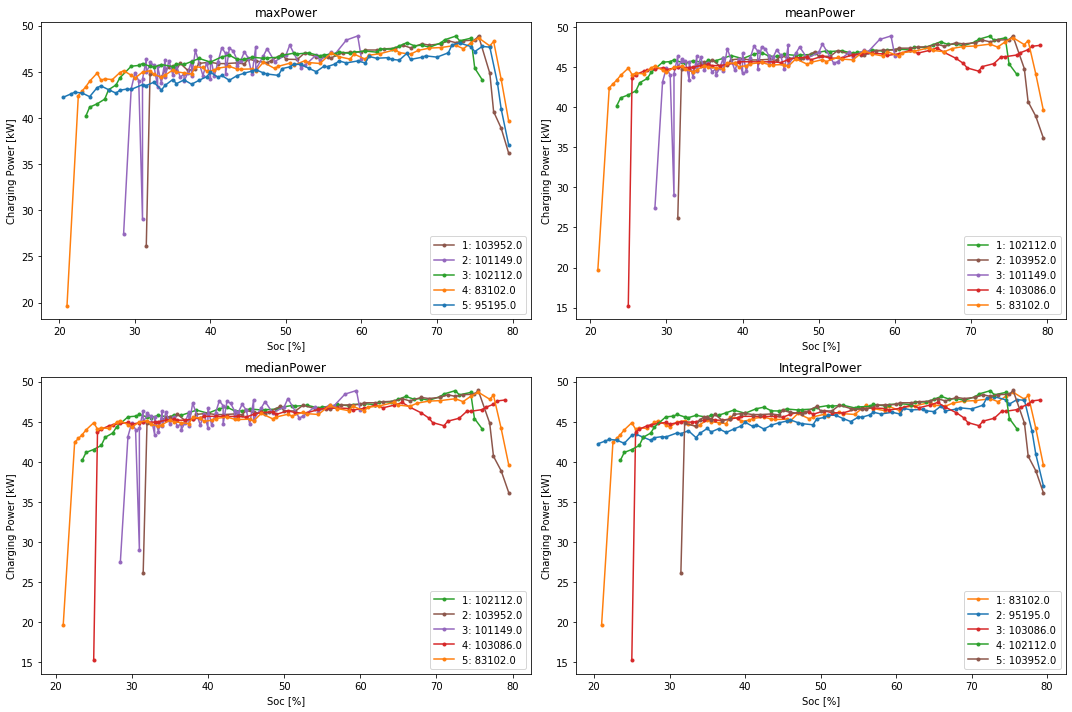

In [5]:
plot_sorting(HyundaiChargeCurve,mask)            

Nach genauer Betrachtung der 50kW-Kurven scheint der Mittelwert Metrik das beste Ergebnis zu liefern. Obwohl mit vollständigeren Daten die Integration besser sein könnte, muss dies in Zukunft überprüft werden.

Biete beachten, dass bei der Median/Mittel-Methode Charge Point 102112 (grüne Kurve) bekommt Platz 1 und 83102 (orange) Platz 5 wäre. Die Integrationsmethode kehrt dieses Ergebnis jedoch nahezu um, d.h. die orangefarbene Kurve liegt auf Platz 1 und die grüne Kurve auf Platz 4. Bei visueller Überprüfung hat die grüne Kurve jedoch ein etwas besseres Verhalten (höhere Leistung) fast im gesamten SoC-Bereich (\~30 bis 74%), während die orange Kurve in diesem Bereich eine etwas geringere Ladeleistung (\~1kW) hat, aber um 20%SoC und über 75% eine höhere Ladeleistung als die grüne Kurve. Dies ist der Grund, warum die Integrationsmethode diese als die beste wählt. Es werden mehr Daten benötigt, um wirklich zu entscheiden, welches die beste Methode zur Auswahl der besten Kurve ist.

Jetzt, betrachten wir die 350kW-Ladepunktkurven.

In [6]:
mask = (HyundaiChargeCurve.data.soc_display > 20) \
        & (HyundaiChargeCurve.data.soc_display < 80) \
        & (HyundaiChargeCurve.data.chargepoint_kw == 350)

res = sorting(HyundaiChargeCurve,mask)
res_sorted = res.sort_values(by='IntegralPower', ascending=False) 
res_sorted

chargePoint     kw          sum   maxPower  meanPower  medianPower  \
1     101322.0  350.0  2882.287380  66.850698  60.047654    63.129576   
2     101226.0  350.0  2376.368106  67.093620  64.226165    64.069316   
0     125383.0  350.0   308.464653  61.977798  61.692931    61.796702   

   IntegralPower  
1    3510.767753  
2    3033.539377  
0     308.427924

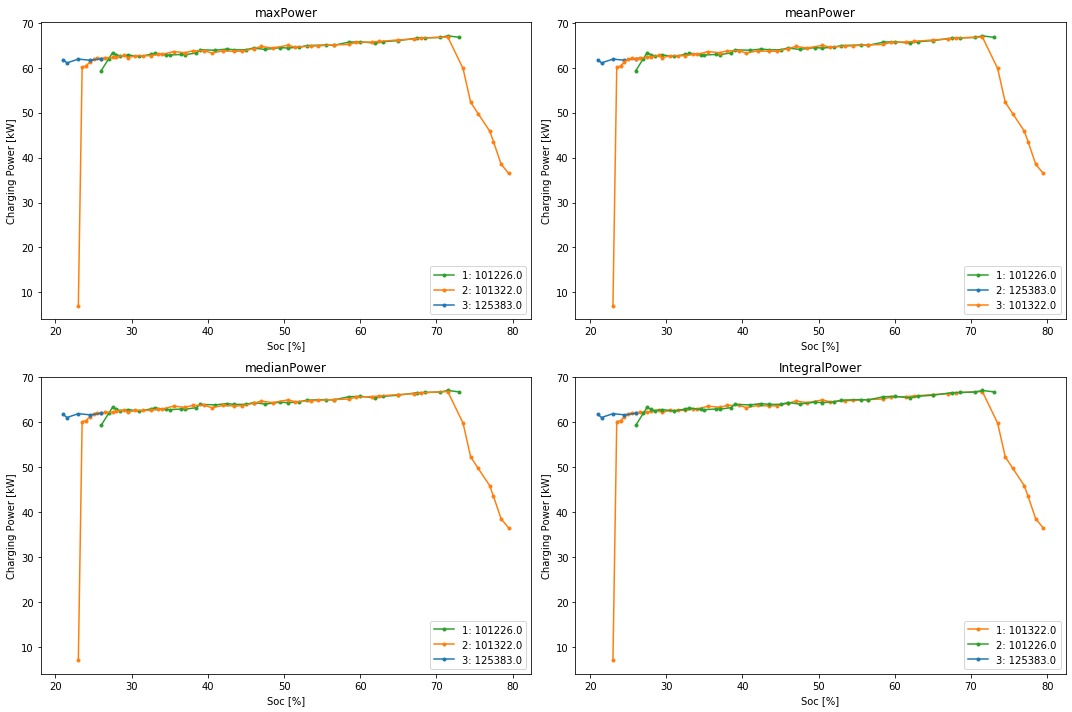

In [7]:
plot_sorting(HyundaiChargeCurve,mask)

Es scheint, dass auch hier ist er Mittelwert-/Median die beste Methode bisher. Um Ausreißer-problem- zu vermeiden, ist es wahrscheinlich besser, den Median zu nehmen.  Trotzdem, als schon gesagt, sobald die Daten vollständiger sind, müssen wir die Integrationsmethode überprüfen.

## Qualitätsbewertung

Jetzt können wir der Ladestation einen Qualitätsbewertungsfaktor hinzufügen, der ihre Leistung mit anderen Ladestationen auf Basis ihrer Ladekurven vergleicht.

Diese Q Score wird so berechnet:

$Q = \frac{\alpha_i}{\alpha_{max}}$

$\alpha_i$: Metrik Wert der Ladekurve an einer Charge Point.

$\alpha_{max}$: Höchsten Metrik Wert dazwischen Charge Points mit gleicher Ladeleistung.

Diese verfahren ist in die ChargingCurve Class als Methode implementiert und ergibt eine Tabelle mit den verschieden Metrik und Qualitätsbewertung ('chargePoint_quality').  Unten ist ein Beispiel diese Methode.

In [8]:
HyundaiChargeCurve.getChargePointQuality(method='mean')

chargePoint  meanPower  medianPower  IntegralPower  chargePoint_quality  \
1     106334.0   4.102356     4.073440      14.386145             1.000000   
0      91058.0   3.128499     3.166240       9.414832             0.762610   
2     101226.0  64.226165    64.069316    3033.539377             1.000000   
0     125383.0  61.692931    61.796702     308.427924             0.960558   
1     101322.0  60.047654    63.129576    3510.767753             0.934941   
2     102112.0  46.192800    46.587502    2436.773973             1.000000   
5     103952.0  45.701261    46.338601    2220.594271             0.989359   
4     101149.0  45.263533    45.983199    1440.465900             0.979883   
3     103086.0  45.259230    45.668319    2470.573282             0.979790   
1      83102.0  45.171307    45.361999    2664.588308             0.977886   
0      95195.0  44.823550    44.884101    2653.939083             0.970358   
0      28547.0   2.995614     3.009330     123.341685             1.000000   
0     124683.0  63.553425    63.450088    2939.768013             1.000000   
0     106765.0  61.174816    62.520992    3171.624130             1.000000   

   chargePoint_quality_int  chargePoint_power  
1                 1.000000               22.0  
0                 0.654437               22.0  
2                 0.864067              350.0  
0                 0.087852              350.0  
1                 1.000000              350.0  
2                 0.914503               50.0  
5                 0.833372               50.0  
4                 0.540596               50.0  
3                 0.927188               50.0  
1                 1.000000               50.0  
0                 0.996003               50.0  
0                 1.000000                3.7  
0                 1.000000               86.0  
0                 1.000000              160.0

## Andere Hersteller

Hier analysierien wir Ladedaten von Ladevorgänge andere Autohersteller.

### Kia eNiro

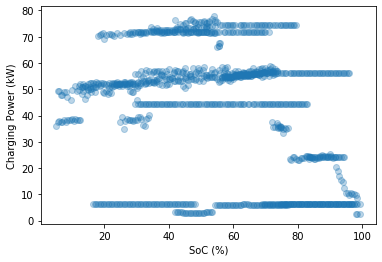

In [9]:
#load kia data
kia = load_base2_ftp('ecu_bcddc2d0718c')
kia = kia[kia.model == 'KIAENIRO']

#select while charging data, for kia the conditions are as below
mask = (kia.hvBatteryCurrent < 0) & (kia.rpmEmotor <=0) \
#& (kia.timestamp > datetime.datetime(2020,1,13)) \

#find peaks to extract charging curves
peaks_id = get_peaks(kia[mask], 'hvSocActualDisplay')

kia_charges = collect_charges(kia[mask], peaks_id)

# instantiate the ChargingCurve object
KiaChargeCurve = ChargingCurve(kia_charges)

#plot the complete Charging Curve for this Auto
KiaChargeCurve.plotCurve()

In [10]:
KiaChargeCurve.getChargePointQuality()

chargePoint  meanPower  medianPower  IntegralPower  chargePoint_quality  \
3     102176.0  69.031644    71.654941    3565.810242             1.000000   
0     106735.0  55.282878    56.076136    2773.988167             0.782586   
1     102135.0  56.977253    55.306671    3439.042907             0.771847   
2     102128.0  50.468941    54.071613    2461.295127             0.754611   
0     125383.0  65.171287    71.119176    3574.812126             1.000000   
0      99060.0  44.413316    44.393999    2220.574405             1.000000   
0       3425.0   3.121448     3.078800      35.866798             1.000000   

   chargePoint_quality_int  chargePoint_power  
3                 1.000000              150.0  
0                 0.777940              150.0  
1                 0.964449              150.0  
2                 0.690248              150.0  
0                 1.000000              350.0  
0                 1.000000               50.0  
0                 1.000000               11.0

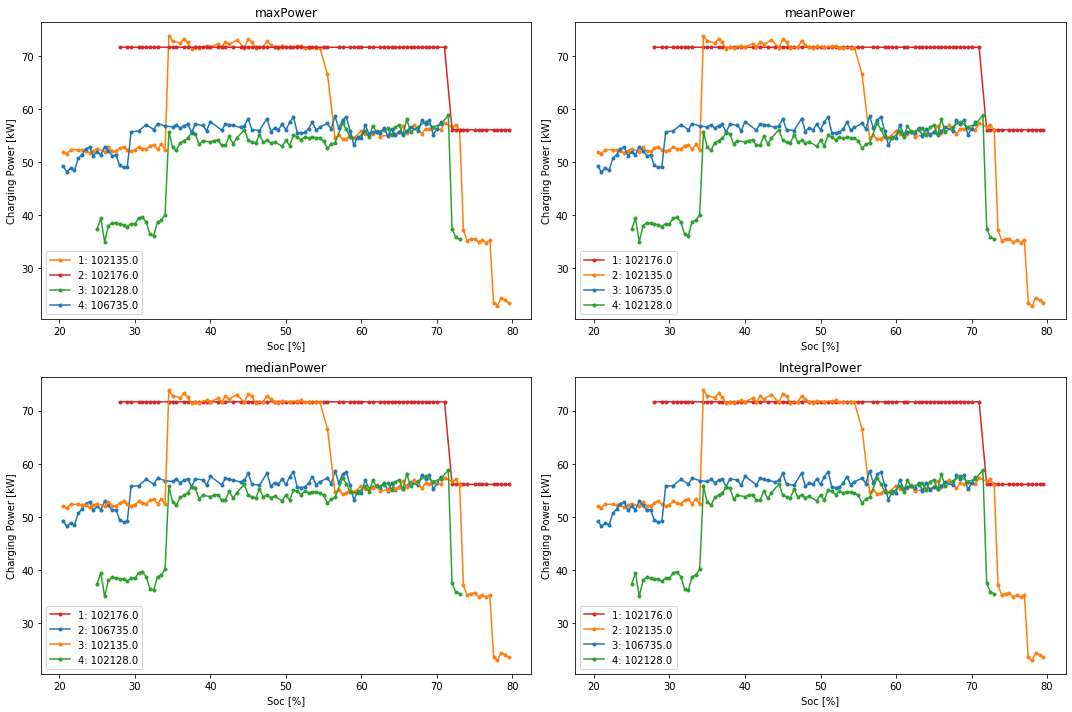

In [11]:
mask = (KiaChargeCurve.data.soc_display > 20) \
        & (KiaChargeCurve.data.soc_display < 80) \
        & (KiaChargeCurve.data.chargepoint_kw == 150)

plot_sorting(KiaChargeCurve,mask)

Die oben Graph zeigt die sortierte Daten nach den verschiedenen Metrik bis jetzt betrachtet. Alle Methoden haben die rote Kurve korrekt in erste Platz platziert. 

Zwischen die anderen Kurven, die orange (Charge Point 102135) ist die, die am Platz 2 sein soll, allerdings, nur der Mittelwert und Integral Methoden haben die Kurve korrekt beurteilt.

### Tesla

Für die Tesla  gibt es nicht genügend Daten, trotzdem zeigen wir hier die Methode Vergleichung für Charge Points mit 50kW Ladeleistung.

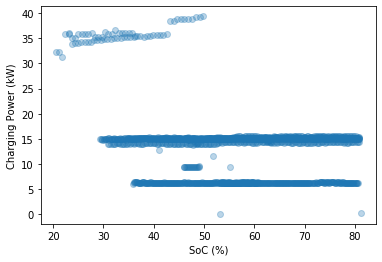

In [12]:
#load tesla data
tesla = load_base2_ftp('ecu_bcddc2ceb734')
tesla = tesla[tesla.model == 'TESLA_S']

#select while charging data, for Tesla the conditions are as below
mask = (tesla.hvBatteryCurrent > 0) & (tesla.rpmEmotor <=0) 

#find peaks to extract charging curves
peaks_id = get_peaks(tesla[mask], 'hvSocActualDisplay')

#collect all data for each charging curve at store it as AutoCharge() objects
tesla_charges = collect_charges(tesla[mask],peaks_id)

# instantiate the ChargingCurve object
TeslaChargeCurve = ChargingCurve(tesla_charges)

#plot the complete Charging Curve for this Auto
TeslaChargeCurve.plotCurve()

In [13]:
TeslaChargeCurve.getChargePointQuality()

chargePoint  meanPower  medianPower  IntegralPower  chargePoint_quality  \
0     105042.0  35.361537    35.935812     556.627661             1.000000   
1      83102.0  35.969550    35.334063     957.519057             0.983255   
2     103952.0  15.357879    15.469801     378.623598             0.430484   
0     103985.0  15.086046    15.092410     761.266132             1.000000   
1     102077.0  14.863846    14.883128      29.730591             0.986133   

   chargePoint_quality_int  chargePoint_power  
0                 0.581323               50.0  
1                 1.000000               50.0  
2                 0.395421               50.0  
0                 1.000000               22.0  
1                 0.039054               22.0

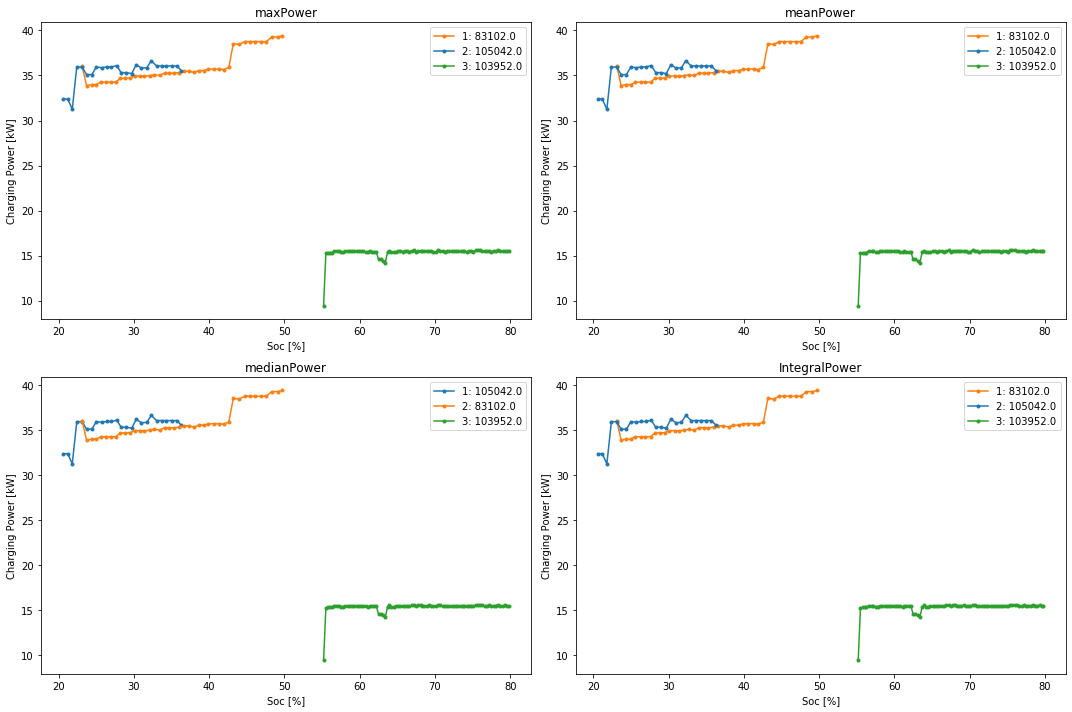

In [14]:
mask = (TeslaChargeCurve.data.soc_display > 20) \
        & (TeslaChargeCurve.data.soc_display < 80) \
        & (TeslaChargeCurve.data.chargepoint_kw == 50)

plot_sorting(TeslaChargeCurve,mask)

## Zusammenfassung

Wir haben ein Qualitätsbewertung implementiert um der besten Ladekurve bei einer bestimmter Ladeleistung. Dafür haben wir Metrik wie Mittelwert, Median und Fläche unter der Kurve benutzt. Die drei Metrik liefern gute Ergebnisse aber jeder haben Einschränkungen wie beeinflusst der Ausreißer oder Unvollständigkeit der Daten.

Mehr Daten sind notwendig um zu entscheiden, welche davon bei  Implementierung zu nutzen. Obwohl, für derzeitige Zustand Median ist vielleicht die beste Lösung.